# MNIST DDPM + DPS Inpainting (Hello World)

What this notebook does:
1) Train a tiny DDPM (noise-prediction) on MNIST (28×28).
2) Define an inpainting operator (mask).
3) Use DPS (likelihood guidance) during the reverse process to sample from the posterior p(x|y).
4) Visualize: original, masked measurement, DPS reconstruction, unconditional baseline.

You can speed this up by reducing steps/epochs or using GPU.


In [18]:
# Cell 1 — Imports & Config
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print("Using device:", device)

# Diffusion hyperparameters
T = 400  # number of diffusion steps


Using device: mps


### Load MNIST Data

In [19]:
# Cell 2 — Dataset & DataLoader (normalized to [-1,1])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # crucial!
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=2, pin_memory=True)


# Diffusion Parameters

In [20]:
# Cell 3 — Diffusion schedule
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)


### Tiny model (barebones CNN)

In [ ]:
# Cell 4 — Tiny but robust DDPM model
class TinyDDPM(nn.Module):
    def __init__(self, T, t_dim=32, channels=128):  # bumped channels
        super().__init__()
        self.t_emb = nn.Embedding(T, t_dim)
        self.net = nn.Sequential(
            nn.Conv2d(1 + t_dim, channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, 1, 3, padding=1)
        )

    def forward(self, x, t):
        t_emb = self.t_emb(t).unsqueeze(-1).unsqueeze(-1)
        t_emb = t_emb.expand(-1, -1, x.size(2), x.size(3))
        x_in = torch.cat([x, t_emb], dim=1)
        return self.net(x_in)


In [ ]:
class SmallUNet(nn.Module):
    def __init__(self, T, t_dim=32, base_channels=64):
        super().__init__()
        self.t_emb = nn.Embedding(T, t_dim)

        # Down
        self.conv1 = nn.Conv2d(1 + t_dim, base_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(base_channels, base_channels * 2, 4, stride=2, padding=1)

        # Bottleneck
        self.conv3 = nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding=1)

        # Up
        self.upconv = nn.ConvTranspose2d(base_channels * 2, base_channels, 4, stride=2, padding=1)
        self.conv_out = nn.Conv2d(base_channels * 2, 1, 3, padding=1)  # concat skip

    def forward(self, x, t):
        t_emb = self.t_emb(t).unsqueeze(-1).unsqueeze(-1)
        t_emb = t_emb.expand(-1, -1, x.size(2), x.size(3))
        x_in = torch.cat([x, t_emb], dim=1)

        # Down path
        d1 = F.relu(self.conv1(x_in))
        d2 = F.relu(self.conv2(d1))

        # Bottleneck
        b = F.relu(self.conv3(d2))

        # Up path + skip
        u = F.relu(self.upconv(b))
        u = torch.cat([u, d1], dim=1)
        out = self.conv_out(u)
        return out


In [ ]:
model = SmallUNet(T).to(device)


Training Loop

In [22]:
# Cell 5 — Training loop

epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(epochs):
    model.train()
    total_loss, count = 0.0, 0
    for x0, _ in train_loader:
        x0 = x0.to(device)
        t = torch.randint(0, T, (x0.size(0),), device=device)
        noise = torch.randn_like(x0)

        a_bar = alpha_bars[t].view(-1,1,1,1)
        x_t = torch.sqrt(a_bar)*x0 + torch.sqrt(1 - a_bar)*noise

        eps_pred = model(x_t, t)
        loss = F.mse_loss(eps_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x0.size(0)
        count += x0.size(0)

    avg_loss = total_loss / count
    print(f"Epoch {epoch+1}/{epochs} - avg loss: {avg_loss:.4f}")


Epoch 1/10 - avg loss: 0.1815
Epoch 2/10 - avg loss: 0.0927
Epoch 3/10 - avg loss: 0.0811
Epoch 4/10 - avg loss: 0.0739
Epoch 5/10 - avg loss: 0.0705
Epoch 6/10 - avg loss: 0.0684
Epoch 7/10 - avg loss: 0.0663
Epoch 8/10 - avg loss: 0.0648
Epoch 9/10 - avg loss: 0.0628
Epoch 10/10 - avg loss: 0.0622


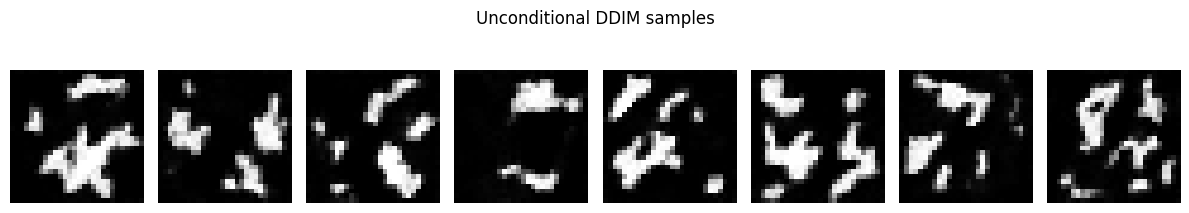

In [25]:
# Cell 6 — Deterministic DDIM sampling

@torch.no_grad()
def predict_x0(x_t, t, eps_pred):
    a_bar = alpha_bars[t].view(-1,1,1,1)
    return (x_t - torch.sqrt(1 - a_bar)*eps_pred) / torch.sqrt(a_bar)

@torch.no_grad()
def ddim_sample(model, n=8, steps=100):
    model.eval()
    x = torch.randn(n, 1, 28, 28, device=device)
    ts = torch.linspace(T-1, 0, steps, device=device).long()
    for i, t_val in enumerate(ts):
        t = t_val.expand(n).to(device)
        eps_pred = model(x, t)
        x0_hat = predict_x0(x, t, eps_pred)
        if i == steps - 1:
            x = x0_hat
        else:
            t_next = ts[i+1].expand(n)
            a_bar_next = alpha_bars[t_next].view(-1,1,1,1)
            x = torch.sqrt(a_bar_next)*x0_hat + torch.sqrt(1 - a_bar_next)*eps_pred
    return x.clamp(-1,1)


# Visualize generated samples
samples = ddim_sample(model, n=8, steps=100)
def to_img(x): return (x.clamp(-1,1)+1)/2

plt.figure(figsize=(12,2))
for i in range(samples.size(0)):
    plt.subplot(1, samples.size(0), i+1)
    plt.imshow(to_img(samples[i,0]).cpu(), cmap='gray'); plt.axis('off')
plt.suptitle("Unconditional DDIM samples", y=1.05)
plt.tight_layout(); plt.show()
